<a href="https://colab.research.google.com/github/polarabbit/booksbot/blob/master/vix_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
import datetime
from sklearn import linear_model
import math
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import asarray
from scipy.stats import pearsonr
import seaborn as sns
from datetime import date, timedelta, datetime
from dateutil import parser
from matplotlib import pyplot as plt
from sklearn.tree import export_text
from sklearn import tree, datasets
import jinja2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, confusion_matrix

In [ ]:
download = "^GSPC ^IXIC ^VIX"
df = yf.download(download, start = "1990-01-01", end = "2022-10-15")["Adj Close"]
df1 = yf.download("^GSPC ^IXIC ^VIX VXX VXZ", start = "2018-01-26", end = "2022-10-15")["Adj Close"]

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  5 of 5 completed


In [ ]:
df1["diff"]=df1["VXZ"]-df1["VXX"]

Text(0.5, 1.0, '^GSPC S&P500')

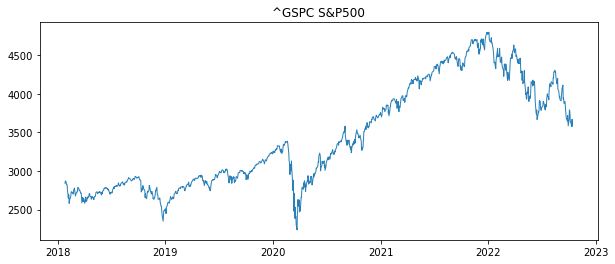

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(df1['^GSPC'], color = '#2980B9', linewidth = 1, label = 'S&P500')
plt.title("^GSPC S&P500")

Text(0.5, 1.0, '^VIX VIX - spot')

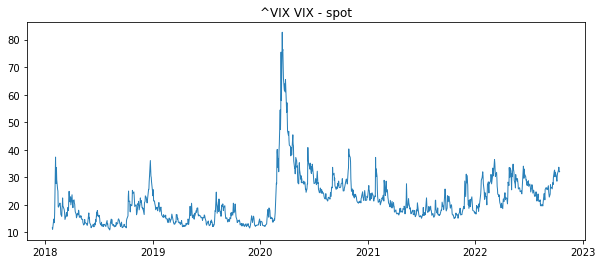

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(df1['^VIX'], color = '#2980B9', linewidth = 1, label = 'VIX - spot')
plt.title("^VIX VIX - spot")

Text(0.5, 1.0, 'VXX VIX - short term')

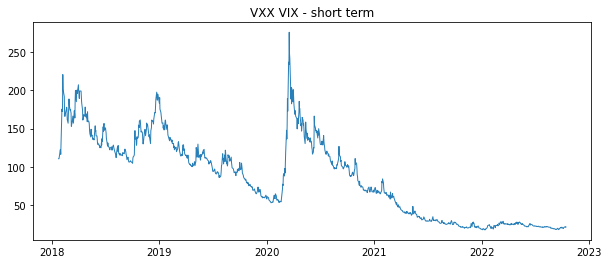

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(df1['VXX'], color = '#2980B9', linewidth = 1, label = 'VIX - short-term')
plt.title("VXX VIX - short term")

Text(0.5, 1.0, 'VXZ VIX - medium-term')

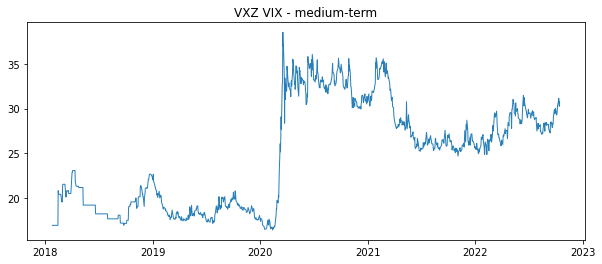

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(df1['VXZ'], color = '#2980B9', linewidth = 1, label = 'VIX - medium-term')
plt.title("VXZ VIX - medium-term")

In [134]:
def perform_adf_test(series):
    result=adfuller(series)
    print ('ADF stats: %f' % result[0])
    print('p-value: %f' % result[1])

In [ ]:
#only VIX is stationary 
#only VIX is stationary 
perform_adf_test(df1.VXX),perform_adf_test(df1.VXZ),perform_adf_test(df1['^GSPC']),perform_adf_test(df1['^VIX']),
perform_adf_test(df1['diff'])

ADF stats: -1.601127
p-value: 0.483027
ADF stats: -1.753281
p-value: 0.403891
ADF stats: -1.376431
p-value: 0.593522
ADF stats: -3.852622
p-value: 0.002413
ADF stats: -1.405305
p-value: 0.579730


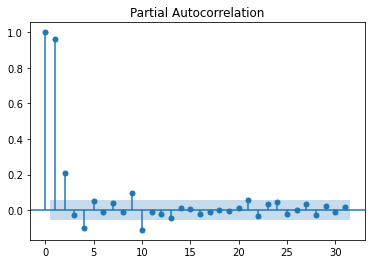

In [ ]:
pacf_plot= plot_pacf(df1['^VIX'])

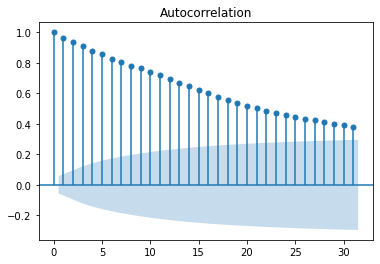

In [ ]:
acf_plot= plot_acf(df1['^VIX'])

In [ ]:
#ARMA model for VIX

In [ ]:
first_diffs_sp500=(df1['^GSPC']-df1['^GSPC'].shift(1)).dropna()

Text(0.5, 1.0, 'first_diffs_sp500')

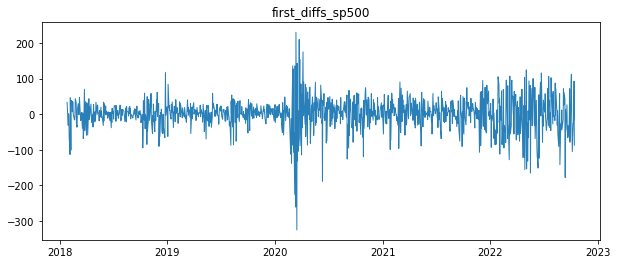

In [ ]:
plt.figure(figsize =(10,4))
plt.plot(first_diffs_sp500, color = '#2980B9', linewidth = 1, label = 'first_diffs_sp500')
plt.title("first_diffs_sp500")

In [ ]:
#stationary first diff sp 500
perform_adf_test(first_diffs_sp500)

ADF stats: -10.794711
p-value: 0.000000


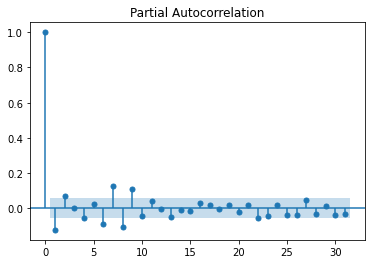

In [ ]:
pacf_plot= plot_pacf(first_diffs_sp500)

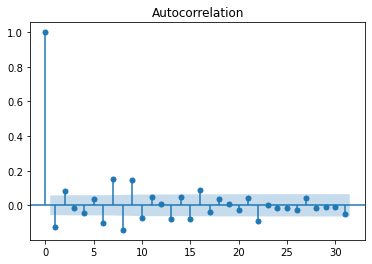

In [ ]:
acf_plot= plot_acf(first_diffs_sp500)

In [ ]:
#modeling SP500 first difference
model=ARMA(first_diffs_sp500,order=(1,1))

C:\Users\Bing\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Bing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

In [ ]:
model_fit=model.fit()

In [ ]:
prediction_info=model_fit.forecast(21)

predictions = prediction_info[0]
lower_bound = prediction_info[2][:,0]
upper_bound = prediction_info[2][:,1]

In [ ]:
predictions,lower_bound,upper_bound

(array([14.98661471, -5.47904119,  3.23238736]),
 array([-71.63600401, -92.76520973, -84.17346886]),
 array([101.60923343,  81.80712736,  90.63824358]))

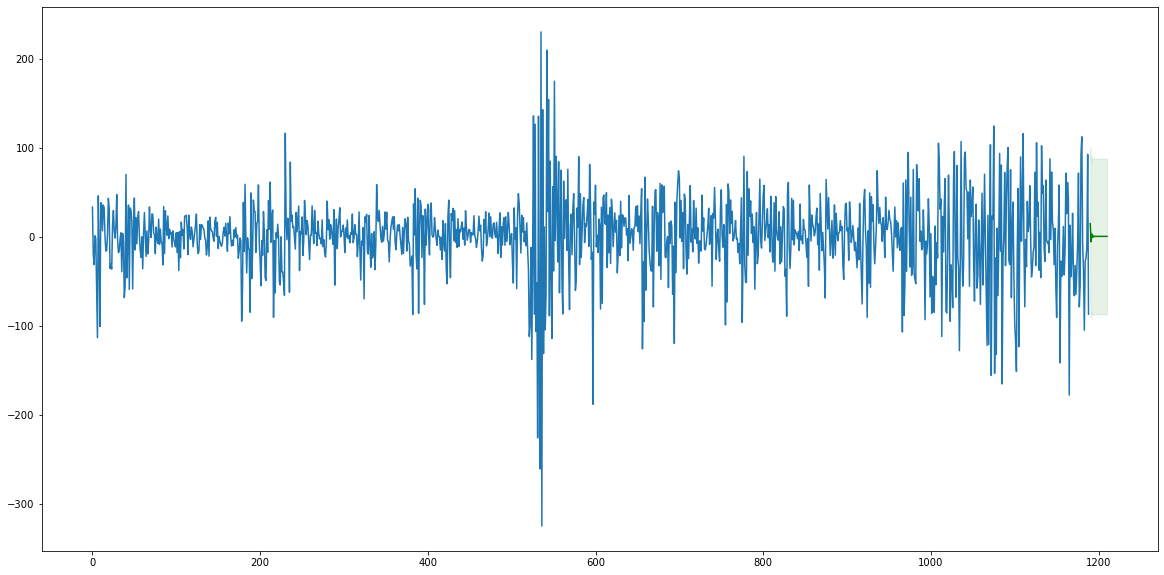

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(first_diffs_sp500.reset_index().drop("Date",axis=1))
plt.plot(np.arange(len(first_diffs_sp500)+1,len(first_diffs_sp500)+22),predictions,color='g')
plt.fill_between(np.arange(len(first_diffs_sp500)+1,len(first_diffs_sp500)+22),lower_bound,upper_bound,color='g',alpha=0.1)

In [ ]:
def undo_transformations(predictions, series):
    first_pred = series.iloc[-1]+predictions[0]
    orig_predictions =[first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = orig_predictions[-1]+predictions[i+1]
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [ ]:
orig_predictions= undo_transformations(predictions,df1['^GSPC'] )
orig_lower_bound = undo_transformations(lower_bound, df1['^GSPC'])
orig_upper_bound = undo_transformations(upper_bound, df1['^GSPC'])

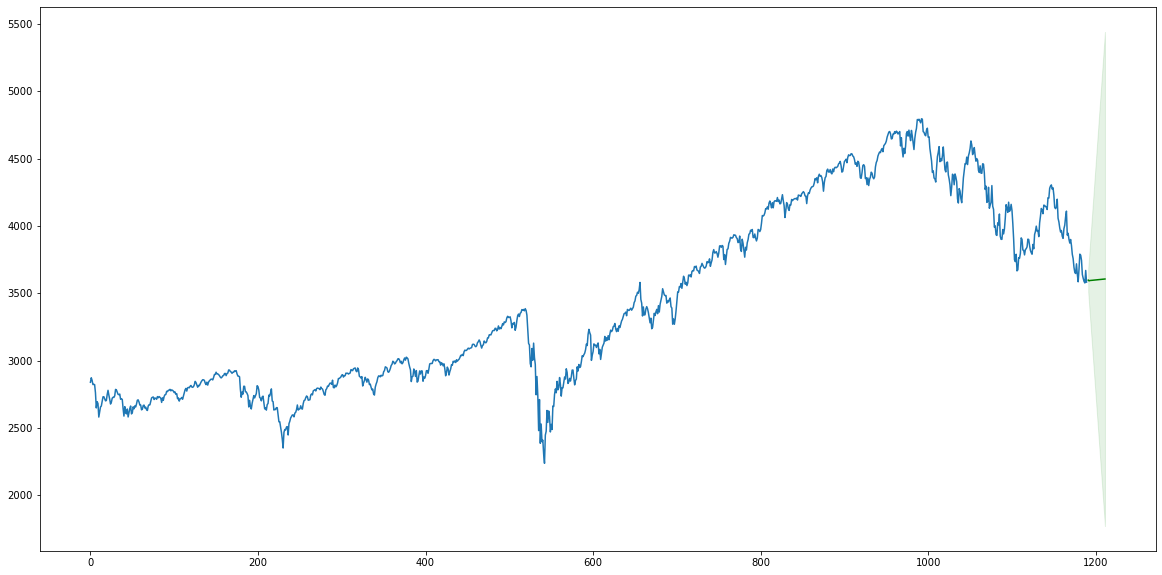

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df1['^GSPC'].reset_index().drop("Date",axis=1))
plt.plot(np.arange(len(df1['^GSPC'])+1,len(df1['^GSPC'])+22),orig_predictions,color='g')
plt.fill_between(np.arange(len(df1['^GSPC'])+1,len(df1['^GSPC'])+22),orig_lower_bound,orig_upper_bound,color='g',alpha=0.1)

In [98]:
vix_futures_csv = 'https://raw.githubusercontent.com/ayoubbensakhria/wqu690/master/data/vix_futures.csv'
vix_futures = pd.read_csv(vix_futures_csv, parse_dates=True)

In [99]:
vix_futures.index = pd.to_datetime(vix_futures['Date']).dt.date

In [100]:
vix_df=vix_futures.drop(columns=['Date']).iloc[:,0:6]

In [101]:
vix_df=vix_df[::-1]

In [102]:
vix_df.index=pd.to_datetime(vix_df.index)

In [103]:
vix_df

,VIX,M1,M2,VIX3M,VXX,SPX
Date,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,22.70,1978.3500
2016-03-02,17.09,19.30,20.25,19.92,22.32,1986.4500
2016-03-03,16.70,18.35,19.50,19.49,21.58,1993.4000
2016-03-04,16.86,18.95,20.00,19.63,21.84,1999.9900
2016-03-07,17.35,18.60,19.80,19.90,21.90,2001.7600
...,...,...,...,...,...,...
2022-04-04,18.57,21.00,23.21,23.03,24.43,4582.6401
2022-04-05,21.03,22.85,24.55,24.90,24.81,4525.1201
2022-04-06,22.10,23.95,25.53,25.80,24.38,4481.1499


In [110]:
vix_df['after_1m'] = vix_df['SPX'].shift(-21)

In [116]:
vix_df['rolling 1m return'] = (vix_df['after_1m']-vix_df['SPX'])/vix_df['SPX'] 

In [119]:
vix_df['rolling 1m return'].describe()

count    1519.000000
mean        0.012106
std         0.045058
min        -0.329668
25%        -0.004360
50%         0.017670
75%         0.034303
max         0.251144
Name: rolling 1m return, dtype: float64

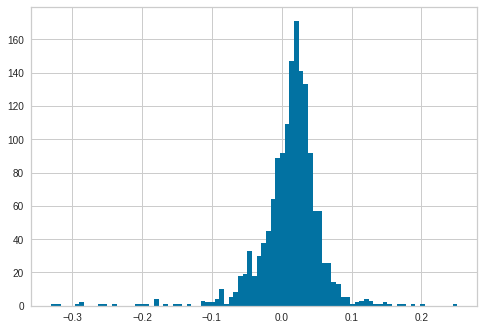

In [118]:
plt.hist(vix_df['rolling 1m return'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [120]:
vix_df["c0"]=vix_df["M1"]/vix_df["VIX"]-1
vix_df["c1"]=vix_df["M2"]/vix_df["M1"]-1
vix_df["c2"]=vix_df["VIX3M"]/vix_df["M2"]-1
vix_df["SP500 return"]=np.log(vix_df['SPX'])-np.log(vix_df['SPX']).shift(1)

In [121]:
rho = vix_df.corr()
pval = vix_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

,VIX,M1,M2,VIX3M,VXX,SPX,rolling 1m return,after_1m,c0,c1,c2,SP500 return
VIX,1.0***,0.979***,0.93***,0.97***,0.328***,0.253***,0.313***,0.297***,-0.593***,-0.61***,0.579***,-0.161***
M1,0.979***,1.0***,0.977***,0.989***,0.28***,0.318***,0.324***,0.359***,-0.451***,-0.545***,0.447***,-0.121***
M2,0.93***,0.977***,1.0***,0.987***,0.19***,0.405***,0.314***,0.445***,-0.369***,-0.383***,0.335***,-0.086***
VIX3M,0.97***,0.989***,0.987***,1.0***,0.24***,0.364***,0.322***,0.407***,-0.468***,-0.461***,0.472***,-0.113***
VXX,0.328***,0.28***,0.19***,0.24***,1.0***,-0.218***,0.172***,-0.169***,-0.36***,-0.497***,0.366***,-0.047*
SPX,0.253***,0.318***,0.405***,0.364***,-0.218***,1.0***,-0.083***,0.982***,-0.039,0.07***,0.032,0.024
rolling 1m return,0.313***,0.324***,0.314***,0.322***,0.172***,-0.083***,1.0***,0.106***,-0.1***,-0.123***,0.109***,-0.044*
after_1m,0.297***,0.359***,0.445***,0.407***,-0.169***,0.982***,0.106***,1.0***,-0.07***,0.06**,0.055**,0.014
c0,-0.593***,-0.451***,-0.369***,-0.468***,-0.36***,-0.039,-0.1***,-0.07***,1.0***,0.563***,-0.822***,0.207***
c1,-0.61***,-0.545***,-0.383***,-0.461***,-0.497***,0.07***,-0.123***,0.06**,0.563***,1.0***,-0.622***,0.165***


In [123]:
before_2020=vix_df[:'2020-1-1']
after_2020=vix_df['2020-1-1':]

In [124]:
rho = before_2020.corr()
pval = before_2020.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

,VIX,M1,M2,VIX3M,VXX,SPX,rolling 1m return,after_1m,c0,c1,c2,SP500 return
VIX,1.0***,0.96***,0.877***,0.959***,0.401***,0.069**,0.173***,0.108***,-0.743***,-0.752***,0.536***,-0.256***
M1,0.96***,1.0***,0.949***,0.965***,0.337***,0.036,0.162***,0.073**,-0.551***,-0.728***,0.342***,-0.204***
M2,0.877***,0.949***,1.0***,0.954***,0.187***,-0.035,0.145***,-0.001,-0.449***,-0.489***,0.153***,-0.158***
VIX3M,0.959***,0.965***,0.954***,1.0***,0.298***,-0.02,0.152***,0.015,-0.638***,-0.617***,0.439***,-0.202***
VXX,0.401***,0.337***,0.187***,0.298***,1.0***,0.599***,0.024,0.6***,-0.395***,-0.518***,0.415***,-0.054*
SPX,0.069**,0.036,-0.035,-0.02,0.599***,1.0***,-0.115***,0.967***,-0.152***,-0.196***,0.037,0.028
rolling 1m return,0.173***,0.162***,0.145***,0.152***,0.024,-0.115***,1.0***,0.139***,-0.112***,-0.109***,0.058*,-0.057*
after_1m,0.108***,0.073**,-0.001,0.015,0.6***,0.967***,0.139***,1.0***,-0.175***,-0.217***,0.046,0.014
c0,-0.743***,-0.551***,-0.449***,-0.638***,-0.395***,-0.152***,-0.112***,-0.175***,1.0***,0.533***,-0.789***,0.253***
c1,-0.752***,-0.728***,-0.489***,-0.617***,-0.518***,-0.196***,-0.109***,-0.217***,0.533***,1.0***,-0.569***,0.205***


In [125]:
rho = after_2020.corr()
pval = after_2020.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

,VIX,M1,M2,VIX3M,VXX,SPX,rolling 1m return,after_1m,c0,c1,c2,SP500 return
VIX,1.0***,0.975***,0.919***,0.971***,0.782***,-0.633***,0.428***,-0.518***,-0.66***,-0.785***,0.715***,-0.186***
M1,0.975***,1.0***,0.973***,0.988***,0.811***,-0.636***,0.479***,-0.512***,-0.502***,-0.741***,0.579***,-0.153***
M2,0.919***,0.973***,1.0***,0.98***,0.821***,-0.623***,0.523***,-0.482***,-0.41***,-0.593***,0.462***,-0.125***
VIX3M,0.971***,0.988***,0.98***,1.0***,0.813***,-0.62***,0.504***,-0.484***,-0.536***,-0.674***,0.619***,-0.153***
VXX,0.782***,0.811***,0.821***,0.813***,1.0***,-0.927***,0.368***,-0.822***,-0.401***,-0.519***,0.393***,-0.05
SPX,-0.633***,-0.636***,-0.623***,-0.62***,-0.927***,1.0***,-0.205***,0.942***,0.412***,0.492***,-0.314***,0.04
rolling 1m return,0.428***,0.479***,0.523***,0.504***,0.368***,-0.205***,1.0***,0.131***,-0.094**,-0.14***,0.146***,-0.039
after_1m,-0.518***,-0.512***,-0.482***,-0.484***,-0.822***,0.942***,0.131***,1.0***,0.367***,0.475***,-0.27***,0.027
c0,-0.66***,-0.502***,-0.41***,-0.536***,-0.401***,0.412***,-0.094**,0.367***,1.0***,0.606***,-0.862***,0.2***
c1,-0.785***,-0.741***,-0.593***,-0.674***,-0.519***,0.492***,-0.14***,0.475***,0.606***,1.0***,-0.69***,0.15***


In [130]:
#label buy and sell signals
#1 buy, 0 hold, -1 sell, threshold +-1%
signal = []
for row in vix_df['rolling 1m return']:
    if row < -0.03 :    signal.append(-1)  
    elif row< 0.01: signal.append(0)
    else:           signal.append(1)

vix_df["signal"]=signal

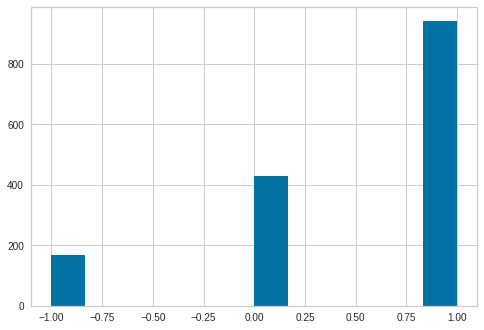

In [131]:
#plot rolling returns distribution
plt.hist(vix_df['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [135]:
vix_df

,VIX,M1,M2,VIX3M,VXX,SPX,rolling 1m return,after_1m,c0,c1,c2,SP500 return,signal
Date,,,,,,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,22.70,1978.3500,0.041140,2059.74,0.096045,0.046392,-0.000985,NaN,1
2016-03-02,17.09,19.30,20.25,19.92,22.32,1986.4500,0.043459,2072.78,0.129315,0.049223,-0.016296,0.004086,1
2016-03-03,16.70,18.35,19.50,19.49,21.58,1993.4000,0.036485,2066.13,0.098802,0.062670,-0.000513,0.003493,1
2016-03-04,16.86,18.95,20.00,19.63,21.84,1999.9900,0.022590,2045.17,0.123962,0.055409,-0.018500,0.003300,1
2016-03-07,17.35,18.60,19.80,19.90,21.90,2001.7600,0.032421,2066.66,0.072046,0.064516,0.005051,0.000885,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,18.57,21.00,23.21,23.03,24.43,4582.6401,NaN,NaN,0.130856,0.105238,-0.007755,0.008058,1
2022-04-05,21.03,22.85,24.55,24.90,24.81,4525.1201,NaN,NaN,0.086543,0.074398,0.014257,-0.012631,1
2022-04-06,22.10,23.95,25.53,25.80,24.38,4481.1499,NaN,NaN,0.083710,0.065971,0.010576,-0.009764,1


In [132]:
#contangos
contangos_c0= vix_df.loc[vix_df['c0'] >0]
contangos_c1= vix_df.loc[vix_df['c1'] >0]
contangos_c2= vix_df.loc[vix_df['c2'] >0]
#backwardation
back_c0= vix_df.loc[vix_df['c0'] <=0]
back_c1= vix_df.loc[vix_df['c1'] <=0]
back_c2= vix_df.loc[vix_df['c2'] <=0]

In [136]:
#stationary series
perform_adf_test(vix_df.c0),perform_adf_test(vix_df.c1),perform_adf_test(vix_df.c2),perform_adf_test(vix_df['rolling 1m return'].dropna())

ADF stats: -5.038803
p-value: 0.000019
ADF stats: -6.228838
p-value: 0.000000
ADF stats: -4.632420
p-value: 0.000113
ADF stats: -5.550460
p-value: 0.000002


(None, None, None, None)

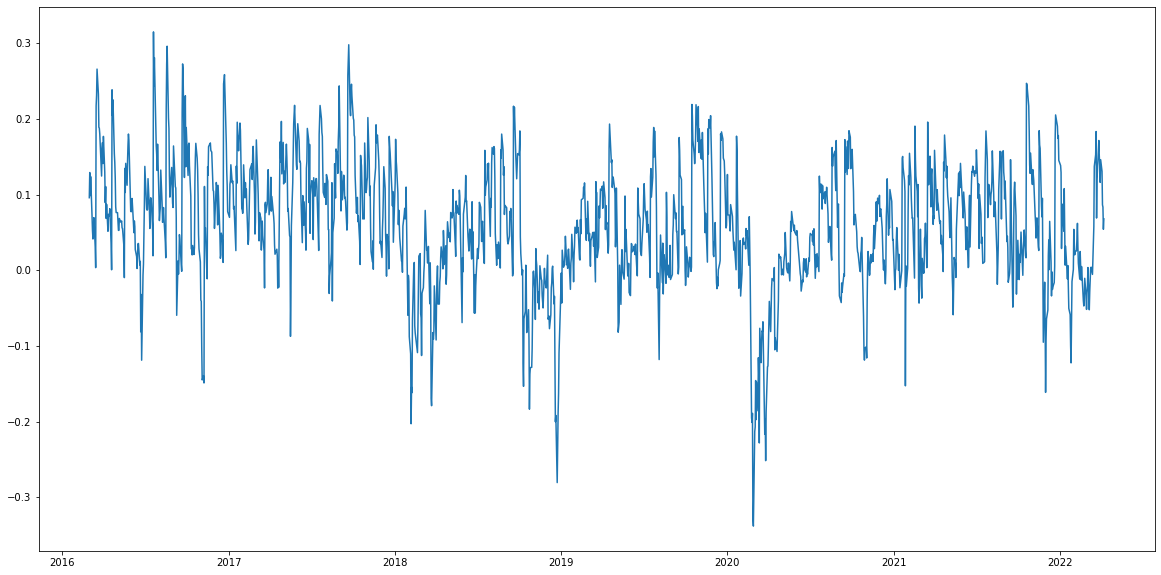

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(vix_df['c0'])

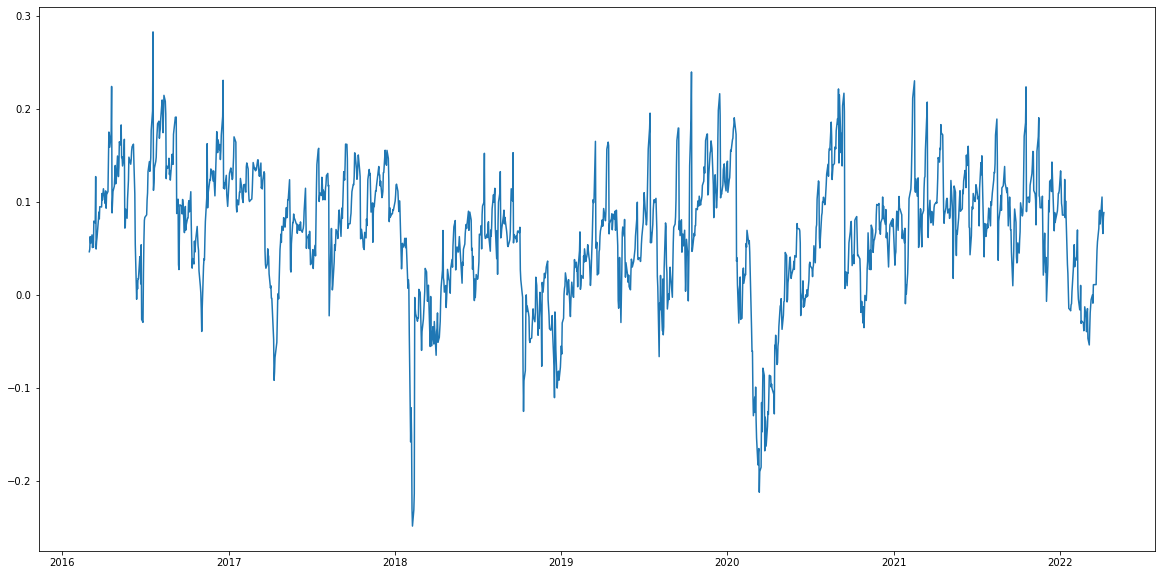

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(vix_df['c1'])

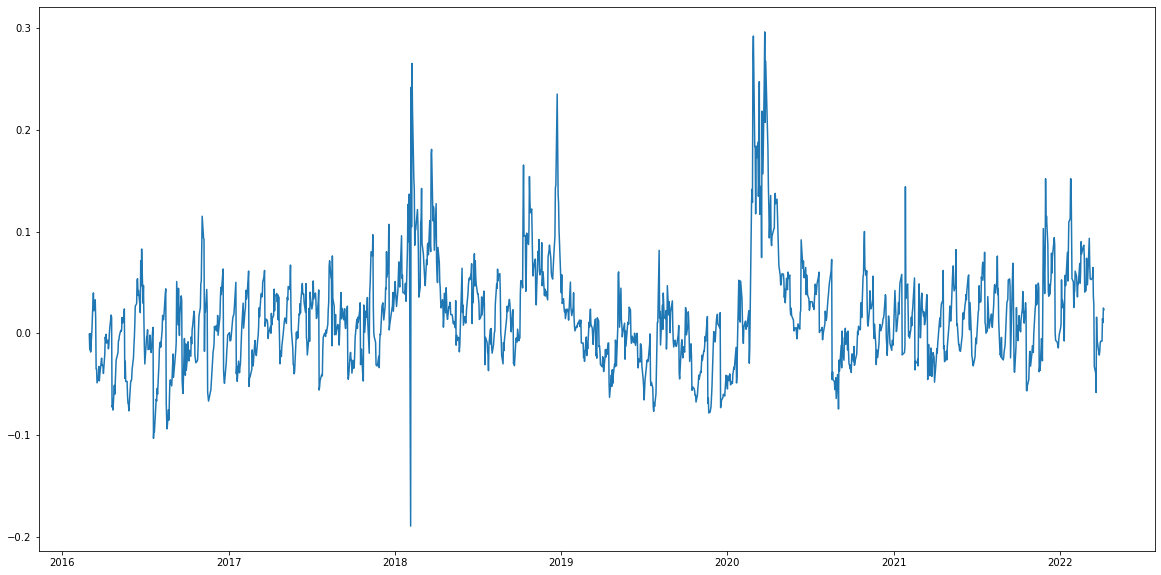

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(vix_df['c2'])

In [139]:
vix_df=vix_df.dropna()
#LR1
X = vix_df[['VIX','c0','c1','SPX','VXX']]
Y = vix_df['rolling 1m return']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:      rolling 1m return   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     57.64
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           5.34e-55
Time:                        16:49:43   Log-Likelihood:                 2684.2
No. Observations:                1518   AIC:                            -5356.
Df Residuals:                    1512   BIC:                            -5324.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.006     -3.389      0.0

In [140]:
X = vix_df[['VIX','c0','c1','c2']]
y = vix_df['rolling 1m return']


In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [142]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
regr = linear_model.LinearRegression()

# fit the model to the training data (learn the coefficients)
regr.fit(X_train, y_train)

LinearRegression()

In [143]:
print(regr.intercept_)
print(regr.coef_)


-0.0345939816476859
[ 0.00222544  0.04765642  0.04500179 -0.00432011]


In [144]:
X_train.shape,X_test.shape

((1138, 4), (380, 4))

In [145]:
y_pred = regr.predict(X_test)

In [146]:
from sklearn import metrics
#Mean Absolute Error (MAE) 
print(metrics.mean_absolute_error(y_test, y_pred))
#Mean Squared Error (MSE)
print(metrics.mean_squared_error(y_test, y_pred))
#Root Mean Squared Error (RMSE)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.02843685797800111
0.001982061573844393
0.04452035010918482


In [147]:
est = sm.OLS(y_train, X_train)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:      rolling 1m return   R-squared (uncentered):                   0.139
Model:                            OLS   Adj. R-squared (uncentered):              0.136
Method:                 Least Squares   F-statistic:                              45.86
Date:                Sun, 16 Oct 2022   Prob (F-statistic):                    9.53e-36
Time:                        16:51:15   Log-Likelihood:                          1981.1
No. Observations:                1138   AIC:                                     -3954.
Df Residuals:                    1134   BIC:                                     -3934.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [19]:
#pip install --user pycaret-ts-alpha

In [1]:
#compare models
from pycaret.classification import *
#s = setup(data=y_train, X_train, target= signal)

In [81]:
vix_df.columns

Index(['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'SPX', 'before_1m',
       'rolling 1m return', 'c0', 'c1', 'c2', 'SP500 return', 'signal'],
      dtype='object')

In [149]:
train_data_0=vix_df.sample(frac=0.9,random_state=345)
test_data_0 = vix_df.drop(train_data_0.index)
train_data=train_data_0.drop(['rolling 1m return','after_1m'],axis=1)
test_data=test_data_0.drop(['rolling 1m return','after_1m'],axis=1)
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)


In [53]:
from pycaret.classification import *

In [150]:
s=setup(data=train_data,target='signal',session_id=	345)

INFO:logs:PyCaret ClassificationExperiment
INFO:logs:Logging name: clf-default-name
INFO:logs:ML Usecase: MLUsecase.CLASSIFICATION
INFO:logs:version 3.0.0
INFO:logs:Initializing setup()
INFO:logs:self.USI: e132
INFO:logs:self.variable_keys: {'seed', 'y', 'y_test', 'gpu_param', 'y_train', 'fold_groups_param', 'data', '_all_models', 'pipeline', '_all_metrics', 'fold_param', 'fold_groups_param_full', 'n_jobs_param', 'idx', 'html_param', '_gpu_n_jobs_param', 'fix_imbalance_param', 'memory', 'fold_generator', 'exp_id', 'X', 'iterative_imputation_iters_param', 'X_test', 'imputation_regressor', 'display_container', 'logging_param', 'imputation_classifier', 'fix_imbalance_method_param', 'log_plots_param', 'experiment__', 'X_train', 'master_model_container', 'fold_shuffle_param', 'stratify_param', 'exp_name_log', 'USI', '_all_models_internal', 'target_param', '_ml_usecase', '_available_plots', 'variable_keys'}
INFO:logs:Checking environment
INFO:logs:python_version: 3.7.14
INFO:logs:python_buil

,Description,Value
0,Session id,345
1,Target,signal
2,Target type,classification
3,Data shape,"(1366, 11)"
4,Train data shape,"(956, 11)"
5,Test data shape,"(410, 11)"
6,Numeric features,10
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


INFO:logs:setup() successfully completed in 0.42s...............


In [152]:
#compare models
model= compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7867,0.8856,0.7233,0.7859,0.7820,0.6019,0.6068,0.297
rf,Random Forest Classifier,0.7700,0.8726,0.6793,0.7655,0.7618,0.5648,0.5704,0.548
lightgbm,Light Gradient Boosting Machine,0.7699,0.8631,0.6995,0.7693,0.7647,0.5703,0.5752,0.326
gbc,Gradient Boosting Classifier,0.7417,0.8416,0.6310,0.7366,0.7284,0.5029,0.5139,0.829
dt,Decision Tree Classifier,0.7144,0.7469,0.6547,0.7203,0.7145,0.4858,0.4883,0.033
knn,K Neighbors Classifier,0.6967,0.8193,0.6104,0.6937,0.6931,0.4438,0.4459,0.127
lr,Logistic Regression,0.5868,0.6371,0.3563,0.4986,0.4869,0.0558,0.0814,0.414
ridge,Ridge Classifier,0.5868,0.0000,0.3391,0.4652,0.4509,0.0144,0.0350,0.043
dummy,Dummy Classifier,0.5868,0.5000,0.3333,0.3444,0.4340,0.0000,0.0000,0.027
lda,Linear Discriminant Analysis,0.5847,0.6363,0.3616,0.5286,0.4947,0.0604,0.0914,0.029


INFO:logs:master_model_container: 28
INFO:logs:display_container: 3
INFO:logs:ExtraTreesClassifier(n_jobs=-1, random_state=345)
INFO:logs:compare_models() successfully completed......................................


In [153]:
#creaete Extra Trees Classifier
et_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7812,0.8998,0.6777,0.7784,0.7732,0.5759,0.5817
1,0.7917,0.9255,0.7038,0.7858,0.7856,0.6098,0.6139
2,0.7708,0.8857,0.6996,0.7627,0.7626,0.5684,0.5738
3,0.7292,0.8334,0.7001,0.7293,0.7279,0.5009,0.5018
4,0.8021,0.8568,0.7717,0.7969,0.7955,0.6320,0.6371
5,0.7188,0.8277,0.6289,0.7109,0.7056,0.4573,0.4665
6,0.8000,0.9058,0.7900,0.8294,0.8058,0.6511,0.6620
7,0.7895,0.8848,0.7116,0.7901,0.7876,0.6126,0.6136
8,0.8316,0.9357,0.7354,0.8260,0.8273,0.6869,0.6891
9,0.8526,0.9011,0.8144,0.8497,0.8487,0.7245,0.7281


INFO:logs:master_model_container: 29
INFO:logs:display_container: 4
INFO:logs:ExtraTreesClassifier(n_jobs=-1, random_state=345)
INFO:logs:create_model() successfully completed......................................


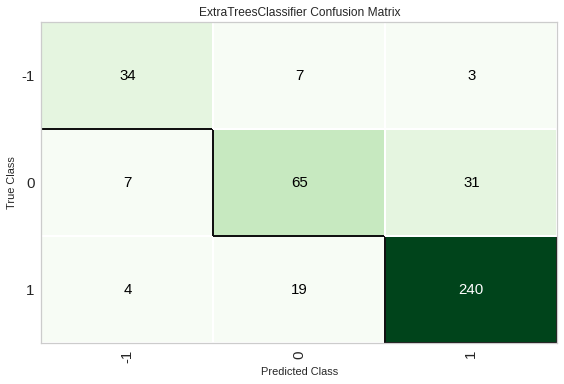

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() successfully completed......................................


In [154]:
plot_model(et_model, plot='confusion_matrix')

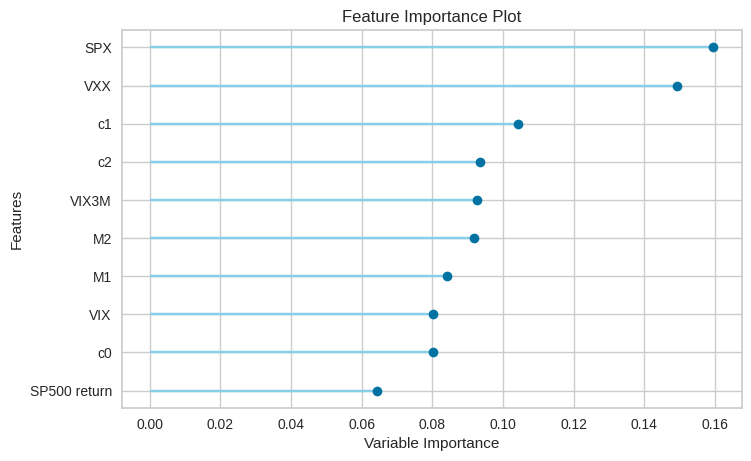

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() successfully completed......................................


In [156]:
plot_model(et_model,plot='feature')

In [157]:
predictions = predict_model(et_model, data=test_data)
predictions, test_data_0

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(n_jobs=-1, random_state=345), probability_threshold=None, encoded_labels=False, raw_score=False, drift_report=False, round=4, verbose=True, ml_usecase=None, display=None, replace_labels_in_column=<function _SupervisedExperiment.predict_model.<locals>.replace_labels_in_column at 0x7f464e220f80>, self=<pycaret.classification.oop.ClassificationExperiment object at 0x7f46588ca850>)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


(       VIX     M1     M2  VIX3M    VXX        SPX        c0        c1  \
 0    14.44  17.78  18.80  18.14  19.49  2040.5900  0.231302  0.057368   
 1    14.09  15.65  17.40  17.28  17.40  2066.6600  0.110717  0.111821   
 2    15.36  16.70  18.50  18.32  18.48  2047.6000  0.087240  0.107784   
 3    14.85  15.95  18.25  17.97  18.13  2061.7200  0.074074  0.144201   
 4    13.22  16.20  18.00  16.64  16.01  2091.5800  0.225416  0.111111   
 ..     ...    ...    ...    ...    ...        ...       ...       ...   
 147  19.61  20.95  22.93  23.50  19.38  4696.0498  0.068332  0.094511   
 148  28.81  27.65  26.82  29.11  23.36  4304.7598 -0.040264 -0.030018   
 149  31.02  29.56  28.42  30.88  24.70  4225.5000 -0.047066 -0.038566   
 150  33.32  31.60  30.35  32.59  26.67  4306.2598 -0.051621 -0.039557   
 151  35.13  34.14  32.82  35.00  28.15  4170.7002 -0.028181 -0.038664   
 
            c2  SP500 return  Label  Score  
 0   -0.035106      0.006574      1   0.06  
 1   -0.006897      

In [158]:
save_model(et_model,'vix_trading_signal')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=ExtraTreesClassifier(n_jobs=-1, random_state=345), model_name=vix_trading_signal, prep_pipe_=Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransfomerWrapper(include=['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'SPX', 'c0', 'c1', 'c2', 'SP500 return'], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransfomerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant')))]), verbose=True, use_case=MLUsecase.CLASSIFICATION, kwargs={})
INFO:logs:Adding model into prep_pipe
INFO:logs:vix_trading_signal.pkl saved in current working directory
INFO:logs:Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransfomerWrapper(include=['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'SPX', 'c0', 'c1', 'c2', 'SP500 return'], transformer=SimpleImputer())),
                ('categorical_impu

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransfomerWrapper(include=['VIX', 'M1', 'M2', 'VIX3M', 'VXX', 'SPX', 'c0', 'c1', 'c2', 'SP500 return'], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransfomerWrapper(include=[], transformer=SimpleImputer(fill_value='constant', strategy='constant'))),
                 ['trained_model',
                  ExtraTreesClassifier(n_jobs=-1, random_state=345)]]),
 'vix_trading_signal.pkl')

In [ ]:
#backtesting

In [ ]:
volatility = "^VIX VXX VXZ"
vix = yf.download(volatility, start = "2018-01-26", end = "2022-10-15")["Adj Close"]

In [ ]:
vix.describe(), df1.describe()

In [ ]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df1)
print(scaled)

In [ ]:
df_scaled = pd.DataFrame(scaled, columns = ['VXX','VXZ','^GSPC','^IXIC','^VIX','diff','before_1m','rolling','signal'])

In [ ]:
df_scaled=df_scaled.set_index(df1.index)

In [ ]:
#unscaled data plot
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(df1['^VIX'], color = '#E74C3C', linewidth = 1,  label = 'VIX Current')
vix_values.plot(df1['VXX'], color = '#9B59B6', linewidth = 1, label = 'VIX - short-term')
vix_values.plot(df1['VXZ'], color = '#2980B9', linewidth = 1, label = 'VIX - medium-term')

plt.legend(loc = 'upper left')
# Axe prices: SPX and IXIC Close Prices
axe_prices = vix_values.twinx()
axe_prices.plot(df1['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
axe_prices.plot(df1['^IXIC'], color = 'blue', linewidth = 1.5, label = 'Nasdaq')
# add titles to subplots
axe_prices.set_title('VIX futures term sructure historical data | SPX and IXIC Adj Close Values')
# set legend position
plt.legend(loc = 'upper right')

In [ ]:
#scaled data plot
plt.figure(figsize=(10,4))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(df_scaled['^VIX'], color = 'black', linewidth = 1,  label = 'VIX Current')
vix_values.plot(df_scaled['VXX'], color = 'green', linewidth = 1, label = 'VIX - short-term')
vix_values.plot(df_scaled['VXZ'], color = '#2980B9', linewidth = 1, label = 'VIX - medium-term')

plt.legend(loc = 'upper left')
# Axe prices: SPX and IXIC Close Prices
axe_prices = vix_values.twinx()
axe_prices.plot(df_scaled['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
axe_prices.plot(df_scaled['^IXIC'], color = 'blue', linewidth = 1.5, label = 'Nasdaq')
# add titles to subplots
axe_prices.set_title('VIX futures term sructure historical data | SPX and IXIC Adj Close Values')
# set legend position
plt.legend(loc = 'upper right')

In [ ]:
# returns
returns = vix.pct_change()[1:]
print(returns)

In [ ]:
df_scaled['diff']=df_scaled['VXZ']-df_scaled['VXX']

In [ ]:
#correlation
rho = df_scaled.corr()
pval = df_scaled.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
older_2020=df_scaled[:'2020-1-1']
recent_2020=df_scaled['2020-1-1':]
year_2020=df_scaled['2020-1-1':'2021-1-1']
year_2021=df_scaled['2021-1-1':'2022-1-1']
year_2022=df_scaled['2022-1-1':]

In [ ]:
older_2020.describe(),recent_2020.describe(),year_2020.describe(),year_2021.describe(),year_2022.describe()

In [ ]:
rho = recent_2020.corr()
pval = recent_2020.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
rho = older_2020.corr()
pval = older_2020.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(3).astype(str) + p

In [ ]:
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(df_scaled['diff'], color = 'black', linewidth = 1,  label = 'VIX near-medium future spread')
vix_values.plot(df_scaled['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
plt.legend(loc = 'upper right')

In [ ]:
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(older_2020['diff'], color = 'black', linewidth = 1,  label = 'VIX near-medium future spread')
vix_values.plot(older_2020['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
plt.legend(loc = 'upper right')

In [ ]:
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(recent_2020['diff'], color = 'black', linewidth = 1,  label = 'VIX near-medium future spread')
vix_values.plot(recent_2020['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
plt.legend(loc = 'upper right')

In [ ]:
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(year_2021['diff'], color = 'black', linewidth = 1,  label = 'VIX near-medium future spread')
vix_values.plot(year_2021['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
plt.legend(loc = 'upper right')

In [ ]:
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(year_2022['diff'], color = 'black', linewidth = 1,  label = 'VIX near-medium future spread')
vix_values.plot(year_2022['^GSPC'], color = 'red', linewidth = 1.5, label = 'SPX')
plt.legend(loc = 'upper right')

In [ ]:
#calculate returns by rolling 6 months

df1['before_1m'] = df1['^GSPC'].shift(21)

In [ ]:
df1['rolling'] = (df1['^GSPC'] - df1['before_1m'])/df1['^GSPC'] 

In [ ]:
df1['rolling'].describe()

In [ ]:
#plot rolling returns distribution
plt.hist(df1['rolling'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
#label buy and sell signals
movement = []
for row in df1['rolling']:
    if row < -0.01 :    movement.append(-1)  
    elif row< 0.01: movement.append(0)
    else:           movement.append(1)

df1["signal"]=movement

In [ ]:
df1.signal.describe()

In [ ]:
plt.hist(df1['signal'], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
#k means cluster
#Scaling
scaler = StandardScaler().fit(vix_df)
scaler
x_scaled = scaler.transform(vix_df)